In [282]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# Importamos utilidades y modelos de sklearn
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [283]:
# Métrica de evaluación
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

def normailize_df(refDf):
    df = refDf.copy()
    df['año'] = df['fecha'].dt.year
    df['antiguedad'] = df['antiguedad'] + (2016 - df['año']) # Se normaliza la antiguedad.
    df.drop(["direccion", 'descripcion', 'lat', 'lng', 'fecha'], axis=1, inplace=True)
    
    nulltotales = df[df['metrostotales'].isnull()]
    nullcubiertos = df[df['metroscubiertos'].isnull()]
    notnullapart = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] < df['metroscubiertos'])]
    notnullapart2 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] > df['metroscubiertos'])]
    notnullapart3 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] == df['metroscubiertos'])]
 
    df['habitable'] = False
    tipodepropiedades = df.tipodepropiedad.cat.categories.to_list()
    for tipodepropiedad in tipodepropiedades: 

        idsNullMetrosTotales = (df.tipodepropiedad == tipodepropiedad) & (df.metrostotales.isnull())
        idsNullMetrosCubiertos = (df.tipodepropiedad == tipodepropiedad) & (df.metroscubiertos.isnull())
        banos = df[df.tipodepropiedad == tipodepropiedad].banos.mode(dropna=False);
        habitaciones = df[df.tipodepropiedad == tipodepropiedad].habitaciones.mode(dropna=False);

        ## Verificamos si la cantidad de registros con metros cubiertos nulos es mayor a 2/5 de los totales. Si es asi 
        ## los consideramos propiedades no habitables. Y los tratamos de manera diferente
        if(len(nullcubiertos[nullcubiertos.tipodepropiedad == tipodepropiedad]) >= 2/5* len(df[df.tipodepropiedad == tipodepropiedad])):
            df.metrostotales.fillna(0, inplace=True)
            df.metroscubiertos.fillna(0, inplace=True)
        else:
            df[idsNullMetrosTotales]['metrostotales'] =  df[idsNullMetrosTotales]['metroscubiertos']
            df[idsNullMetrosCubiertos]['metroscubiertos'] =  df[idsNullMetrosCubiertos]['metrostotales']

        #Si la moda del tipo de propiedad de banos y habitaciones son ambas distintas de nan entonces la propiedad es habitable.

        df.loc[(df.tipodepropiedad == tipodepropiedad), 'habitable'] = not(numpy.isnan(banos[0]) and numpy.isnan(habitaciones[0]))
            
    return df

In [284]:
df_train = pd.read_csv('train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
df_test = pd.read_csv('test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_train = normailize_df(df_train)
df_test = normailize_df(df_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [288]:

df_train['metros'] = df_train['metrostotales'] + df_train['metroscubiertos']
df_test['metros'] = df_test['metrostotales'] + df_test['metroscubiertos']
df_train['precio_mt2'] = df_train['precio'] / df_train['metros']

tipodepropiedades = df_train.tipodepropiedad.cat.categories.to_list()



def predict_by_prop(idsTrainFil, idsTestFil): 
    for tipodepropiedad in tipodepropiedades: 
        #Solo las propiedades que queremos
        idsTrain = (df_train.tipodepropiedad == tipodepropiedad) & idsTrainFil
        idsTest = (df_test.tipodepropiedad == tipodepropiedad) & idsTestFil
        X = df_train[idsTrain][['metros']]
        y = df_train[idsTrain]['precio_mt2']
#         print('------', tipodepropiedad)
#         print(X.shape, len(y))
        if(len(y) == 0 or len(df_test[idsTest][['metros']]) == 0): 
            continue
        if(len(y) == 1):
    #         print(        df_test[df_test.tipodepropiedad == tipodepropiedad, 'target'])
            df_test.loc[df_test.tipodepropiedad == tipodepropiedad, 'target'] = y.to_list()[0]
            continue
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


        linear_model = LinearRegression().fit(X, y)

        pred = linear_model.predict(df_test[idsTest][['metros']])


        df_test.loc[idsTest, 'target'] = pred

        
dfAntiguedadMenor10Train = (~ df_train["antiguedad"].isnull()) & (df_train["antiguedad"] <= 10)
dfAntiguedadMenor10Test = (~ df_test["antiguedad"].isnull()) & (df_test["antiguedad"] <= 10)

dfAntiguedadMayor10Train = ~dfAntiguedadMenor10Train
dfAntiguedadMayor10Test = ~dfAntiguedadMenor10Test

predict_by_prop(dfAntiguedadMenor10Train, dfAntiguedadMenor10Test)

predict_by_prop(dfAntiguedadMayor10Train, dfAntiguedadMayor10Test)

df_test.loc[df_test.tipodepropiedad.isnull(), 'target'] = df_test['target'].median()
df_test['target'] = df_test['target'] *  df_test['metros']
final_prediction = df_test.copy().drop(df_test.columns.difference(['target']), 1)
# # print()
final_prediction.to_csv('prediction.csv')
df_test['target'].isnull().sum()



0

Text(0.5, 1.05, 'Regresión del costo m2 según tipo de propiedad en base a la antigüedad \n (Ultimos 10 años)')

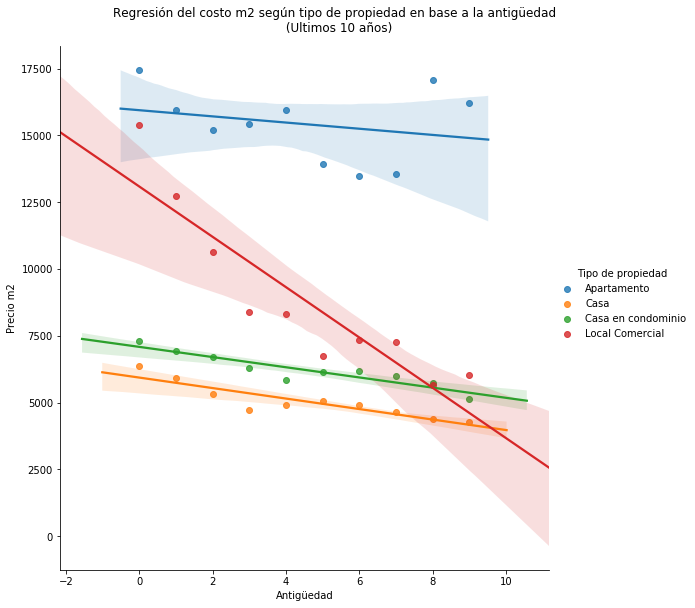

In [287]:
habitables = ['Casa', 'Casa en condominio', 'Apartamento', 'Local Comercial']
dfAntiguedad = df_train[(~ df_train["antiguedad"].isnull()) & (df_train["antiguedad"] < 10) & (df_train["tipodepropiedad"].isin(habitables)) ]

# dfAntiguedad.tipodepropiedad.value_counts()
dfAntiguedad['tipodepropiedad'].cat.remove_unused_categories(inplace=True)
dfAntiguedad = dfAntiguedad.groupby(['antiguedad', 'tipodepropiedad']).agg(prom_precio_mt2=('precio_mt2', 'median')).reset_index()


ax = sns.lmplot(x="antiguedad", y="prom_precio_mt2", data=dfAntiguedad, hue="tipodepropiedad", height=8);

ax.set(xlabel='Antigüedad', ylabel='Precio m2')

new_title = 'Tipo de propiedad'
ax._legend.set_title(new_title)
ax.fig.suptitle('Regresión del costo m2 según tipo de propiedad en base a la antigüedad \n (Ultimos 10 años)', y= 1.05)
